In [16]:
# Imports
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, create_react_agent
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal, TypedDict, Annotated
import operator
import os

print("✅ All imports successful")

✅ All imports successful


In [17]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("openai_key")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found!")

print("✅ API key loaded")

✅ API key loaded


In [18]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


## PlAN-EXECUTE PATTERN

In [19]:
# CUSTOM STATE FOR PLAN-
class PlanExecuteState(TypedDict):
    """State for plan-execute pattern."""
    input: str # Original user query
    plan: list[str] #List of steps
    current_step: int # which step we are on 
    results: Annotated[list[str],operator.add] #results from each step
    final_output: str #final answer


print("✅ Plan-Execute state defined")

✅ Plan-Execute state defined


In [20]:
# Node 1: Planner

def planner(state:PlanExecuteState)->dict:
    """Create a step-by-step plan."""
    prompt = f""" Create a step-by-step plan for this task:
    
Task: {state['input']}
Return a numbered list of concrete steps. keep it simple(3-5 steps)."""
    response= llm.invoke([HumanMessage(content=prompt)])

    #parse steps (simple parsing)

    lines= response.content.split('\n')
    steps=[line.strip() for line in lines if line.strip() and any(char.isdigit() for char in line[:3])]

    print(f"\n📋 PLAN CREATED:")
    for step in steps:
        print(f"  {step}")
    print()
    
    return {"plan": steps, "current_step": 0, "results": []}


# Node 2: Executor

def executor(state: PlanExecuteState) -> dict:
    """Execte current step."""
    if state["current_step"] >= len(state["plan"]):
        #all steps done
        return{}
    
    current_step = state["plan"][state["current_step"]]
    print(f"⚙️ Executing: {current_step}")

    #execute step (simplified - just use llm)
    prompt= f"""Previous results:{state.get('results',[])}\n\nExecute this step: {current_step}"""
    response= llm.invoke([HumanMessage(content=prompt)])

    result = f"Step {state['current_step'] + 1} result: {response.content}"
    print(result)
    print(f"Done\n")

    return {
        "results": [result],
        "current_step": state["current_step"] + 1
    }


#Node 3: Finalizer

def finalizer(state:PlanExecuteState)->dict:
    """Create final output from all results."""
    prompt= f"""Combine these step results into a final answer:
    
Original task: {state['input']}

Results: {state['results']}
Provide a clear, concise final answer."""
    response= llm.invoke([HumanMessage(content=prompt)])
    return {"final_output": response.content}

print("✅ Plan-Execute nodes defined")

✅ Plan-Execute nodes defined


In [21]:
#Routing function
def should_continue_execution(state:PlanExecuteState) -> Literal["executor","finalizer"]:
    """Decide if more steps to execute."""
    if state["current_step"] < len(state["plan"]):
        return "executor"
    return "finalizer"
plan_execute_builder= StateGraph(PlanExecuteState)

plan_execute_builder.add_node("planner",planner)
plan_execute_builder.add_node("executor",executor)
plan_execute_builder.add_node("finalizer", finalizer)

plan_execute_builder.add_edge(START,"planner")
plan_execute_builder.add_edge("planner", "executor")
plan_execute_builder.add_conditional_edges(
    "executor",should_continue_execution,{"executor": "executor", "finalizer": "finalizer"}
)

plan_execute_builder.add_edge("finalizer",END)

plan_execute_agent= plan_execute_builder.compile()

print("✅ Plan-Execute agent created")

✅ Plan-Execute agent created


In [22]:
result = plan_execute_agent.invoke({
    "input": "Research what ReAct pattern is and explain it simply"
})

print(f"\n{'='*70}")
print("📊 FINAL OUTPUT:")
print(f"{'='*70}")
print(result["final_output"])
print(f"{'='*70}\n")


📋 PLAN CREATED:
  1. **Define the ReAct Pattern**: Start by looking up the basic definition of the ReAct pattern in the context of programming or software development. Identify its purpose and key components.
  2. **Gather Resources**: Find reliable sources such as articles, tutorials, or videos that explain the ReAct pattern. Look for examples that illustrate how it is used in real-world applications.
  3. **Summarize Key Points**: Take notes on the most important aspects of the ReAct pattern, including its benefits, use cases, and any common challenges associated with it.
  4. **Create a Simple Explanation**: Write a brief, easy-to-understand explanation of the ReAct pattern, using simple language and avoiding technical jargon. Aim to make it accessible to someone unfamiliar with the concept.
  5. **Review and Refine**: Go over your explanation to ensure clarity and accuracy. Make any necessary adjustments to improve understanding and coherence.

⚙️ Executing: 1. **Define the ReAct 

In [23]:
# Custom state for Reflection
class ReflectionState(TypedDict):
    """State for reflection pattern."""
    task: str  # Original task
    draft: str  # Current draft
    critique: str  # Critique of draft
    iterations: int  # Number of refinements
    final_output: str  # Final result

MAX_REFLECTIONS = 2  # Prevent infinite loops

print("✅ Reflection state defined")

✅ Reflection state defined


In [24]:
def generator(state:ReflectionState) -> dict:
    """Generate or refine based on critique."""
    if state["iterations"] == 0:
        #first generation
        prompt=f"""Create a response for this task:
Task: {state['task']}

Provide a clear, complete answer."""
        print("\n✍️ Generating initial draft...")
    else:
        # Refinement based on critique
        prompt = f"""Improve this draft based on the critique:
Task: {state['task']}

current draft: {state['draft']}

Critique: {state['critique']}

Create an improved version."""
        print(f"\n✍️ Refining (iteration {state['iterations']})...")

    response= llm.invoke([HumanMessage(content=prompt)])
    print("✓ Draft created\n")

    return {"draft": response.content}



# Node 2: Critic
def critic(state: ReflectionState) -> dict:
    """Evaluate draft and provide critique."""
    prompt = f"""Evaluate this response and provide constructive critique:

Task: {state['task']}

Response: {state['draft']}

Critique the response. What could be improved?
If it's excellent, say "APPROVED: explanation".
Otherwise, provide specific improvements needed."""

    print("🔍 Critiquing draft...")
    response = llm.invoke([HumanMessage(content=prompt)])
    critique = response.content
    
    print(f"Critique: {critique[:100]}\n")
    return {
        "critique": critique,
        "iterations": state["iterations"] + 1
    }

# Node 3: Finalizer
def reflection_finalizer(state: ReflectionState) -> dict:
    """Set final output."""
    print("\n✅ Reflection complete!\n")
    return {"final_output": state["draft"]}

print("✅ Reflection nodes defined")


✅ Reflection nodes defined


In [25]:
# Routing function
def should_reflect_again(state: ReflectionState) -> Literal["generator", "finalizer"]:
    """Decide if we need more refinement."""
    # Stop if approved or max iterations
    if "APPROVED" in state.get("critique", "").upper():
        return "finalizer"
    
    if state["iterations"] >= MAX_REFLECTIONS:
        print(f"⚠️ Max iterations ({MAX_REFLECTIONS}) reached\n")
        return "finalizer"
    
    return "generator"

# Build Reflection graph
reflection_builder = StateGraph(ReflectionState)

reflection_builder.add_node("generator", generator)
reflection_builder.add_node("critic", critic)
reflection_builder.add_node("finalizer", reflection_finalizer)

reflection_builder.add_edge(START, "generator")
reflection_builder.add_edge("generator", "critic")
reflection_builder.add_conditional_edges(
    "critic",
    should_reflect_again,
    {"generator": "generator", "finalizer": "finalizer"}  # Can loop back
)
reflection_builder.add_edge("finalizer", END)

reflection_agent = reflection_builder.compile()

print("✅ Reflection agent created")

✅ Reflection agent created


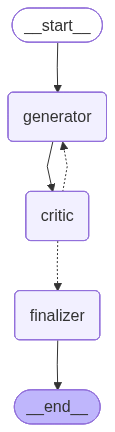

In [26]:
# Visualize
try:
    display(Image(reflection_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → generator → critic (loops back to generator) → finalizer → END")

In [27]:
result = reflection_agent.invoke({
    "task": "Explain what an agentic pattern is in 2-3 sentences",
    "draft": "",
    "critique": "",
    "iterations": 0
})

print(f"\n{'='*70}")
print("📊 FINAL OUTPUT (after reflection):")
print(f"{'='*70}")
print(result["final_output"])
print(f"\nTotal iterations: {result['iterations']}")
print(f"{'='*70}\n")


✍️ Generating initial draft...
✓ Draft created

🔍 Critiquing draft...
Critique: The response provides a clear and concise explanation of what an agentic pattern is, effectively cap


✍️ Refining (iteration 1)...
✓ Draft created

🔍 Critiquing draft...
Critique: The response provides a clear and concise definition of an agentic pattern, highlighting the key asp

⚠️ Max iterations (2) reached


✅ Reflection complete!


📊 FINAL OUTPUT (after reflection):
An agentic pattern is a way of behaving where individuals take charge of their actions and decisions, showing independence and confidence in their abilities. For instance, when someone sets a personal goal and actively works towards it, they exemplify an agentic pattern by shaping their own future instead of simply reacting to external events.

Total iterations: 2

